In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

ng1 = pd.read_csv('C:/Users/aggar/Downloads/Assessment/Assessment/Natural_Gas_Data prices.csv')
positions = pd.read_csv('C:/Users/aggar/Downloads/Assessment/Assessment/Natural_Gas_Data positioning.csv')
inventory = pd.read_csv('C:/Users/aggar/Downloads/Assessment/Assessment/inventory.csv')
hdd = pd.read_csv('C:/Users/aggar/Downloads/Assessment/Assessment/HDD.csv')
cdd = pd.read_csv('C:/Users/aggar/Downloads/Assessment/Assessment/CDD.csv')

for df in [ng1, positions, inventory, hdd, cdd]:
    df['Date'] = pd.to_datetime(df['Date'])

for df in [positions, inventory, hdd, cdd]:
    df.dropna(subset=['Date'], inplace=True)

for df in [ng1, positions, inventory, hdd, cdd]:
    df.sort_values('Date', inplace=True)

pct_cols = ['Percent Producers', 'Percent Swaps', 'Percent Managed Money', 
            'Percent Other Reportable', 'Percent Non-reportable']
for col in pct_cols:
    if col in positions.columns:
        positions[col] = positions[col].astype(str).str.replace('%', '')
        positions[col] = pd.to_numeric(positions[col], errors='coerce')

data = ng1.copy()
data = pd.merge_asof(data, inventory, on='Date', direction='backward')
data = pd.merge_asof(data, positions, on='Date', direction='backward')
data = pd.merge_asof(data, hdd, on='Date', direction='backward')
data = pd.merge_asof(data, cdd, on='Date', direction='backward')
data.sort_values('Date', inplace=True)
data.reset_index(drop=True, inplace=True)



In [2]:
# 2. FEATURE ENGINEERING
# ---------------------------------------------------------------------
# Compute daily return on NG1
data['Price_Change'] = data['NG1'].pct_change()
# Spread
data['Spread'] = data['NG1'] - data['NG2']
# Inventory Change
if 'Inventory (unit: BCF)' in data.columns:
    data['Inventory_Change'] = data['Inventory (unit: BCF)'].diff()
# Weather Impact
if ('HDD' in data.columns) and ('CDD' in data.columns):
    data['Weather_Impact'] = data['HDD'] - data['CDD']
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [3]:
# 3. CALCULATE SIGNALS
# ---------------------------------------------------------------------
# a) Spread Z-Score (20-day rolling window)
window = 20
data['Spread_Mean'] = data['Spread'].rolling(window).mean()
data['Spread_Std'] = data['Spread'].rolling(window).std()
data['Spread_Z'] = (data['Spread'] - data['Spread_Mean']) / data['Spread_Std']

# b) Inventory Signal: use the sign of inventory change (flip sign: increase = bearish)
data['Inventory_Signal'] = -np.sign(data['Inventory_Change'])

# c) Weather Signal: sign of (HDD - CDD); assume higher HDD (more heating) is bullish
data['Weather_Signal'] = np.sign(data['Weather_Impact'])

# Composite Signal: average of signals (flip spread for mean reversion)
data['Composite_Signal'] = (-data['Spread_Z'] + data['Inventory_Signal'] + data['Weather_Signal']) / 3

# 4. VOLATILITY FILTER & POSITION SCALING
# ---------------------------------------------------------------------
# Calculate a 10-day rolling volatility for NG1 returns
vol_window = 10
data['Volatility'] = data['Price_Change'].rolling(vol_window).std()

# Define a volatility scaling factor: e.g., target volatility of 1% daily
target_vol = 0.01
data['Vol_Scale'] = target_vol / data['Volatility']
# Cap the scaling factor to a maximum (e.g., 1.5) and a minimum (e.g., 0.5) to avoid extreme leverage
data['Vol_Scale'] = data['Vol_Scale'].clip(lower=0.5, upper=1.5)

# 5. TRADE SIGNAL GENERATION
# ---------------------------------------------------------------------
# Generate raw signal from composite signal using threshold (0.5)
threshold = 0.5
data['Raw_Signal'] = data['Composite_Signal'].apply(lambda x: 1 if x > threshold else (-1 if x < -threshold else 0))

# Adjust the signal by volatility scaling factor
data['Scaled_Signal'] = data['Raw_Signal'] * data['Vol_Scale']

In [4]:
# 6. DYNAMIC DRAWDOWN RISK MANAGEMENT
# ---------------------------------------------------------------------
# We implement a mechanism to reduce exposure if the portfolio draws down more than 20% from its peak.
portfolio = 1.0
peak = 1.0
risk_managed_signal = []  # final signal after risk management

# We simulate over each day based on the scaled signal
for sig in data['Scaled_Signal']:
    # Check current portfolio relative to peak (simulate in a separate loop later)
    # For now, we append the raw scaled signal; we'll adjust after computing portfolio trajectory.
    risk_managed_signal.append(sig)
data['Risk_Signal'] = risk_managed_signal

# Now simulate portfolio with dynamic risk management:
portfolio_values = []
adjusted_signals = []
portfolio = 1.0
peak = 1.0
target_drawdown = 0.10  # 20%

for i, row in data.iterrows():
    # If current portfolio is more than target_drawdown below peak, reduce signal
    current_drawdown = (portfolio - peak) / peak
    if current_drawdown < -target_drawdown:
        # Reduce exposure to 0 (close positions)
        adj_signal = 0
    else:
        adj_signal = row['Risk_Signal']
    adjusted_signals.append(adj_signal)
    # Update portfolio: use previous day's adjusted signal to compute today's return
    # We use a 1-day lag: today's signal applies to next day return
    # For simulation, we assume signal is applied one day ahead.
    portfolio = portfolio * (1 + adj_signal * row['Price_Change'])
    # Update peak
    if portfolio > peak:
        peak = portfolio
    portfolio_values.append(portfolio)

data['Adjusted_Signal'] = adjusted_signals
data['Dynamic_Portfolio'] = portfolio_values


In [5]:
# 7. PERFORMANCE METRICS
# ---------------------------------------------------------------------
# Compute daily strategy returns based on adjusted signal (applied with 1-day lag)
data['Strategy_Return'] = data['Adjusted_Signal'].shift(1) * data['Price_Change']
data['Strategy_CumReturn'] = (1 + data['Strategy_Return']).cumprod()

# Calculate Sharpe Ratio (risk-free rate assumed 0)
daily_mean = data['Strategy_Return'].mean()
daily_std = data['Strategy_Return'].std()
sharpe_ratio = (daily_mean / daily_std) * np.sqrt(252) if daily_std != 0 else np.nan

# Sortino Ratio: calculate downside deviation
downside_returns = data['Strategy_Return'][data['Strategy_Return'] < 0]
downside_std = np.std(downside_returns) if len(downside_returns) > 0 else 0
annualized_downside_std = downside_std * np.sqrt(252)
annualized_return = daily_mean * 252
sortino_ratio = annualized_return / annualized_downside_std if annualized_downside_std != 0 else np.nan
cum_return = data['Strategy_CumReturn']

print(f'Final Cumulative Return: {(cum_return.iloc[-1]-1)*100:.2f}%')
print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
print(f'Sortino Ratio: {sortino_ratio:.2f}')


Final Cumulative Return: 666.07%
Sharpe Ratio: 0.79
Sortino Ratio: 0.67


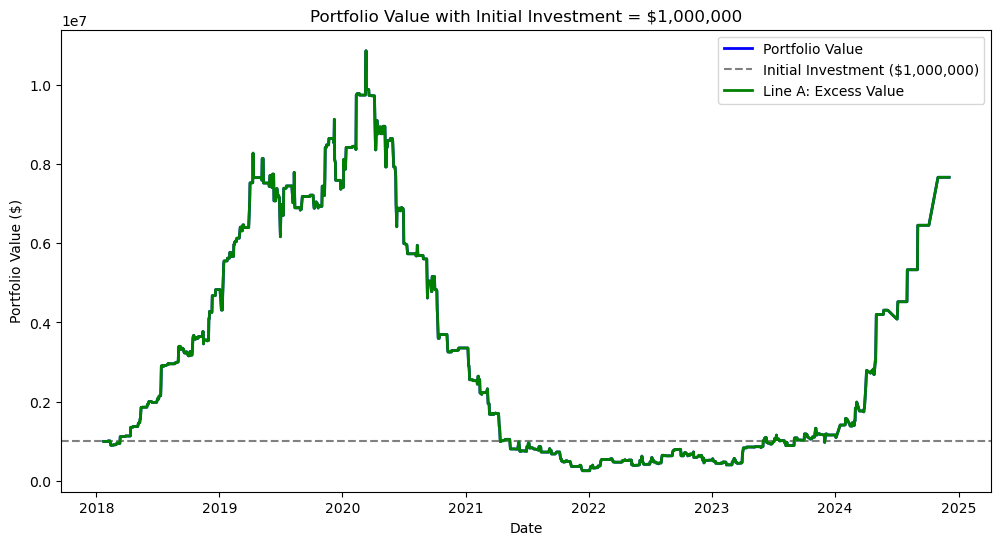

In [6]:
initial_investment = 1000000
data['Portfolio_Value'] = initial_investment * data['Strategy_CumReturn']
data['Excess_Value'] = data['Portfolio_Value'] - initial_investment

plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Portfolio_Value'], label='Portfolio Value', color='blue', linewidth=2)
plt.axhline(initial_investment, color='gray', linestyle='--', label='Initial Investment ($1,000,000)')
plt.plot(data['Date'], data['Excess_Value'] + initial_investment, label='Line A: Excess Value', color='green', linewidth=2)

plt.title('Portfolio Value with Initial Investment = $1,000,000')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()

In [7]:
final_portfolio_value = data['Portfolio_Value'].iloc[-1]
print("Final Portfolio Value: ${:,.2f}".format(final_portfolio_value))


Final Portfolio Value: $7,660,749.66
